In [3]:
# -*- coding: utf-8 -*-
import multiprocessing
import pickle
import time
time.clock= time.time
import sys

from scipy.special import polygamma as pg
from scipy.special import psi as psi

import numpy as np

SMALL_NUMBER = 1e-100

# This is the LDA implementation to use
# K = number of topics
# eta = hyperparameter for topics (i.e. pseudo word counts)
# alpha = initial Dirichlet hyperparameter
# update_alpha = boolean to determine whether or not alpha is updated at each iteration
# word_index is a dictionary storing the position of each feature in numpy arrays
 # word_index is only used in multi-file as it's important that features are always in the same order.
 # In single file it is created internally
class VariationalLDA(object):
    def __init__(self,corpus=None,K = 20,eta=0.1,
        alpha=1,update_alpha=True,word_index=None,normalise = -1,fixed_topics = None,fixed_topics_metadata = None,
        topic_index = None,top_verbose = True):
        self.corpus = corpus
        self.word_index = word_index
        self.normalise = normalise
        #  If the corpus exists, make the word index and the (unused?) word doc matrix
        if not self.corpus == None:
            self.n_docs = len(self.corpus)
            if self.word_index == None:
                self.word_index = self.find_unique_words()
            if top_verbose:
                print ("Object created with {} documents".format(self.n_docs))
            self.n_words = len(self.word_index)
            self.make_doc_index()
            if self.normalise > -1:
                if top_verbose:
                    print ("Normalising intensities")
                #self.normalise_intensities()
        
        self.K = K

        if fixed_topics:
            self.n_fixed_topics = len(fixed_topics)
            self.K += self.n_fixed_topics
        else:
            self.n_fixed_topics = 0


        self.alpha = alpha
        #  If alpha is a single value, make it into a vector
        if type(self.alpha) == int or type(self.alpha) == float:
            self.alpha = self.alpha*np.ones(self.K)
        self.eta = eta # Smoothing parameter for beta
        self.update_alpha = update_alpha
        self.doc_metadata = None
        

        # self.topic_index = topic_index
        # self.topic_metadata = topic_metadata
        self.topic_index = topic_index
        if not self.topic_index:
            self.topic_index = {}
            self.topic_metadata = {}
            topic_pos = 0
            if fixed_topics:
                for topic_name in fixed_topics:
                    self.topic_index[topic_name] = topic_pos
                    #self.topic_metadata[topic_name] = fixed_topics_metadata[topic_name]
                    #self.topic_metadata[topic_name]['type'] = 'fixed'
                    topic_pos += 1
        
            for topic_pos in range(self.n_fixed_topics,self.K):
                topic_name = 'motif_{}'.format(topic_pos)
                #self.topic_index[topic_name] = topic_pos
                #self.topic_metadata[topic_name] = {'name':topic_name,'type':'learnt'}

        if fixed_topics:
            self._add_exact_fixed_topics(fixed_topics)
            

    def _add_exact_fixed_topics(self,fixed_topics):
        # first add any missing words
        #word_pos = max(self.word_index.values())+1

        #for topic,spectrum in fixed_topics.items():
         #   for word in spectrum:
          #      if not word in self.word_index:
           #         self.word_index[word] = word_pos
            #        word_pos += 1
        #self.n_words = len(self.word_index)

        # Now make the fixed rows of beta
        self.beta_matrix = np.zeros((self.K,self.n_words),np.float64) + SMALL_NUMBER
        #self.beta_matrix[0:50,:] = fixed_topics
        for topic_pos,spectrum in fixed_topics.items():
                for word_pos,val in spectrum.items():
                    self.beta_matrix[topic_pos,word_pos] = val
                self.beta_matrix[topic_pos,:] /= self.beta_matrix[topic_pos,:].sum()


    def create_word_index (self,df):
        word_index = {}
        pos = 0
        for word in list(df.T.columns):
            word_index[word] = pos
            pos += 1
        return word_index
   
    def create_doc_index (self,df):
        self.doc_index = {}
        doc_pos = 0
        for doc in list(df.T.index):
            self.doc_index[doc] = doc_pos
            doc_pos += 1
                
    def load_data_sc(self,df):
        print ("Edited")
        self.n_docs = df.T.shape[0]
        self.word_index = self.create_word_index(df)
        self.create_doc_index(df)
        self.n_words = df.T.shape[1]
        self.corpus = df.T.to_dict(orient="index")
        for doc in self.corpus.keys(): 
            self.corpus[doc] = {key:val for key, val in self.corpus[doc].items() if val != 0}
        
 
        
        
   
    # Run the VB inference. Verbose = True means it gives output each iteration
    # initialise = True initialises (i.e. restarts the algorithm)
    # This means we can run the algorithm from where it got to.
    # First time its run, initialise has to be True
    def run_vb(self,n_its = 1,verbose=True,initialise=True):
        if initialise:
            if verbose:
                print ("Initialising")
            self.init_vb()
        if verbose:
            print ("Starting iterations")
        for it in range(n_its):
            start_time = time.clock()
            diff = self.vb_step()
            end_time = time.clock()
            self.its_performed += 1
            estimated_finish = ((end_time - start_time)*(n_its - it)/60.0)
            if verbose:
                print ("Iteration {} (change = {}) ({} seconds, I think I'll finish in {} minutes). Alpha: ({},{})".format(it,diff,end_time - start_time,estimated_finish,self.alpha.min(),self.alpha.max()))

    # D a VB step
    def vb_step(self):
        # Run an e-step
        temp_beta = self.e_step()
        temp_beta += self.eta
        # Do the normalisation in the m step
        if self.n_fixed_topics > 0:
            temp_beta[:self.n_fixed_topics,:] = self.beta_matrix[:self.n_fixed_topics,:]
        temp_beta /= temp_beta.sum(axis=1)[:,None]
        # Compute how much the word probabilities have changed
        total_difference = (np.abs(temp_beta - self.beta_matrix)).sum()
        self.beta_matrix = temp_beta
        # If we're updating alpha, run the alpha update
        if self.update_alpha:
            self.alpha = self.alpha_nr(init_alpha = self.alpha.copy())
        return total_difference
        # self.m_step()

    # Newton-Raphson procedure for updating alpha
    def alpha_nr(self,maxit=20,init_alpha=[]):
        old_alpha = self.alpha.copy()
        try:
            M,K = self.gamma_matrix.shape
            if not len(init_alpha) > 0:
                init_alpha = self.gamma_matrix.mean(axis=0)/K
            alpha = init_alpha.copy()
            alphap = init_alpha.copy()
            g_term = (psi(self.gamma_matrix) - psi(self.gamma_matrix.sum(axis=1))[:,None]).sum(axis=0)
            for it in range(maxit):
                grad = M *(psi(alpha.sum()) - psi(alpha)) + g_term
                H = -M*np.diag(pg(1,alpha)) + M*pg(1,alpha.sum())


                # playing here....
                z = M*pg(1,alpha.sum())
                h = -M*pg(1,alpha)
                c = ((grad/h).sum())/((1.0/z) + (1.0/h).sum())
                alpha_change = (grad - c)/h

                n_bad = (alpha_change > alpha).sum()
                while n_bad > 0:
                    alpha_change/=2.0
                    n_bad = (alpha_change > alpha).sum()

                
                alpha_new = alpha - alpha_change

                pos = np.where(alpha_new <= SMALL_NUMBER)[0]
                alpha_new[pos] = SMALL_NUMBER

                # if (alpha_new < 0).sum() > 0:
                #   init_alpha /= 10.0
                #   return self.alpha_nr(maxit=maxit,init_alpha = init_alpha)

                diff = np.sum(np.abs(alpha-alpha_new))
                alpha = alpha_new
                if diff < 1e-6 and it > 1:
                    return alpha
        except:
            alpha = old_alpha
        return alpha

    # TODO: tidy up and comment this function
    def e_step(self):
        temp_beta = np.zeros((self.K,self.n_words))
        for doc in self.corpus:
            d = self.doc_index[doc]
            temp_gamma = np.zeros(self.K) + self.alpha
            for word in self.corpus[doc]:
                w = self.word_index[word]
                log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T
                # self.phi_matrix[doc][word] = self.beta_matrix[:,w]*np.exp(psi(self.gamma_matrix[d,:])).T
                # for k in range(self.K):
                #   self.phi_matrix[doc][word][k] = self.beta_matrix[k,w]*np.exp(scipy.special.psi(self.gamma_matrix[d,k]))
                log_phi_matrix = np.exp(log_phi_matrix - log_phi_matrix.max())
                self.phi_matrix[doc][word] = log_phi_matrix/log_phi_matrix.sum()
                # self.phi_matrix[doc][word] /= self.phi_matrix[doc][word].sum()
                temp_gamma += self.phi_matrix[doc][word]*self.corpus[doc][word]
                temp_beta[:,w] += self.phi_matrix[doc][word] * self.corpus[doc][word]
            # self.phi_matrix[d,:,:] = (self.beta_matrix * self.word_matrix[d,:][None,:] * (np.exp(scipy.special.psi(self.gamma_matrix[d,:]))[:,None])).T
            # self.phi_matrix[d,:,:] /= self.phi_matrix[d,:,:].sum(axis=1)[:,None]
            # self.gamma_matrix[d,:] = self.alpha + self.phi_matrix[d,:,:].sum(axis=0)
            self.gamma_matrix[d,:] = temp_gamma
            pos = np.where(self.gamma_matrix[d,:]<SMALL_NUMBER)[0]
            self.gamma_matrix[d,pos] = SMALL_NUMBER
        return temp_beta

    # Function to find the unique words in the corpus and assign them to indices
    def find_unique_words(self):
        word_index = {}
        pos = 0
        for doc in self.corpus:
            for word in self.corpus[doc]:
                if not word in word_index:
                    word_index[word] = pos
                    pos += 1
        print ("Found {} unique words".format(len(word_index)))
        return word_index

    # Pretty sure this matrix is never used
    def make_doc_index(self):
        self.doc_index = {}
        doc_pos = 0
        for doc in self.corpus:
            self.doc_index[doc] = doc_pos
            doc_pos += 1

    # Initialise the VB algorithm
    # TODO: tidy this up
    def init_vb(self):
        # self.gamma_matrix = np.zeros((self.n_docs,self.K),np.float) + 1.0
        # self.phi_matrix = np.zeros((self.n_docs,self.n_words,self.K))
        self.its_performed = 0
        self.phi_matrix = {}
        self.gamma_matrix = np.zeros((self.n_docs,self.K))
        for doc in self.corpus:
            self.phi_matrix[doc] = {}
            for word in self.corpus[doc]:
                self.phi_matrix[doc][word] = np.zeros(self.K)
            d = self.doc_index[doc]
            doc_total = 0.0
            for word in self.corpus[doc]:
                doc_total += self.corpus[doc][word]
            self.gamma_matrix[d,:] = self.alpha + 1.0*doc_total/self.K
        # # Normalise this to sum to 1
        # self.phi_matrix /= self.phi_matrix.sum(axis=2)[:,:,None]

        # Initialise the betas
        if self.n_fixed_topics == 0:
            # self.beta_matrix = np.random.rand(self.K,self.n_words)
            self.beta_matrix = np.zeros((self.K,self.n_words),np.double)
            for k in range(self.K):
                self.beta_matrix[k,:] = np.random.dirichlet(self.eta*np.ones(self.n_words)) 
        else:
            print ("Here")
            for k in range(self.n_fixed_topics,self.K):
                self.beta_matrix[k,:] = np.random.dirichlet(self.eta*np.ones(self.n_words))
        self.beta_matrix /= self.beta_matrix.sum(axis=1)[:,None]

    # Function to return a dictionary with keys equal to documents and values equal to the probability
    # of the requested document (used for visusaling in DESI imaging)
    def get_topic_as_doc_dict(self,topic_id,thresh = 0.001,normalise=False):
        top = {}
        mat = self.gamma_matrix
        if normalise:
            mat = self.get_expect_theta()

        for doc in self.doc_index:
            pos = self.doc_index[doc]
            if mat[pos,topic_id] >= thresh:
                top[doc] = mat[pos,topic_id]
        return top

    # Return a topic as a dictionary over words
    def get_topic_as_dict(self,topic_id):
        top = {}
        for word in self.word_index:
            top[word] = self.beta_matrix[topic_id,self.word_index[word]]
        return top

    # Return the topic probabilities for all documents 
    # Note that self.doc_index maps the document names to their
    # position in this matrix
    def get_expect_theta(self):
        e_theta = self.gamma_matrix.copy()
        e_theta /= e_theta.sum(axis=1)[:,None]
        return e_theta

    def get_beta(self):
        return self.beta_matrix.copy()

    def make_dictionary(self,metadata=None,min_prob_to_keep_beta = 1e-3,
        min_prob_to_keep_phi = 1e-2,min_prob_to_keep_theta = 1e-2,
        filename = None,features = None,compute_overlaps = True):

        if metadata == None:
            if self.doc_metadata == None:
                metadata = {}
                for doc in self.corpus:
                    metadata[doc] = {'name': doc,'parentmass': float(doc.split('_')[0])}
            else:
                metadata = self.doc_metadata

        lda_dict = {}
        lda_dict['corpus'] = self.corpus
        lda_dict['word_index'] = self.word_index
        lda_dict['doc_index'] = self.doc_index
        lda_dict['K'] = self.K
        lda_dict['alpha'] = list(self.alpha)
        lda_dict['beta'] = {}
        lda_dict['doc_metadata'] = metadata
        lda_dict['topic_index'] = self.topic_index
        lda_dict['topic_metadata'] = self.topic_metadata
        
        pure_gamma = []
        for gamma in self.gamma_matrix:
            pure_gamma.append(list(gamma))

        lda_dict['gamma'] = gamma

        if features:
            lda_dict['features'] = features

        # Create the inverse indexes
        wi = []
        for i in self.word_index:
            wi.append((i,self.word_index[i]))
        wi = sorted(wi,key = lambda x: x[1])

        di = []
        for i in self.doc_index:
            di.append((i,self.doc_index[i]))
        di = sorted(di,key=lambda x: x[1])

        ri,i = zip(*wi)
        ri = list(ri)
        di,i = zip(*di)
        di = list(di)

        # make a reverse index for topics
        tp = [(topic,self.topic_index[topic]) for topic in self.topic_index]
        tp = sorted(tp,key = lambda x: x[1])
        reverse,_ = zip(*tp)

        for k in range(self.K):
            pos = np.where(self.beta_matrix[k,:]>min_prob_to_keep_beta)[0]
            motif_name = reverse[k]
            # motif_name = 'motif_{}'.format(k)
            lda_dict['beta'][motif_name] = {}
            for p in pos:
                word_name = ri[p]
                lda_dict['beta'][motif_name][word_name] = self.beta_matrix[k,p]

        eth = self.get_expect_theta()
        lda_dict['theta'] = {}
        for i,t in enumerate(eth):
            doc = di[i]
            lda_dict['theta'][doc] = {}
            pos = np.where(t > min_prob_to_keep_theta)[0]
            for p in pos:
                motif_name = reverse[p]
                # motif_name = 'motif_{}'.format(p)
                lda_dict['theta'][doc][motif_name] = t[p]

        lda_dict['phi'] = {}
        ndocs = 0
        for doc in self.corpus:
            ndocs += 1
            lda_dict['phi'][doc] = {}
            for word in self.corpus[doc]:
                lda_dict['phi'][doc][word] = {}
                pos = np.where(self.phi_matrix[doc][word] >= min_prob_to_keep_phi)[0]
                for p in pos:
                    motif_name = reverse[p]
                    lda_dict['phi'][doc][word][motif_name] = self.phi_matrix[doc][word][p]
            if ndocs % 500 == 0:
                print ("Done {}".format(ndocs))

        if compute_overlaps:
            os = compute_overlap_scores(lda_dict)
            lda_dict['overlap_scores'] = os

        if not filename == None:
            with open(filename,'w') as f:
                pickle.dump(lda_dict,f)

        return lda_dict



In [4]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.patches as mpatches

from scipy import spatial
from scipy.stats import binom
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.spatial.distance import cosine
from itertools import combinations

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)


#returns a re-normalised delta: all new topics set to 0; old ones normalised
def deltaCell(cellID,documentTopicMatrix,oldTopics,allTopics):
    theta = documentTopicMatrix.loc[cellID]
    delta = np.zeros(allTopics)
    totalSum = sum(theta[0:oldTopics])
    delta[0:oldTopics] = theta[0:oldTopics]/totalSum
    return delta 


def calculateProbs(cellID, geneName,totalTopics,oldTopics,doubletsMatrix,topicWordsMatrix,documentTopicMatrix):
    total = 0
    total2 = 0
    n = doubletsMatrix.T[cellID].sum()
    x = doubletsMatrix.T[cellID][geneName]
    delta = deltaCell(cellID,documentTopicMatrix,oldTopics, totalTopics)
    p = topicWordsMatrix[geneName][0:totalTopics].values
    prob = (1-binom.cdf(x, n, p))+binom.pmf(x, n, p)
    total = sum(documentTopicMatrix.T[cellID].values*prob)
    total2 = sum(delta*prob)
    return (total, total2)


def expectedActualPlot(geneName,totalTopics,oldTopics,cellMatrix,topicWordsMatrix,documentTopicMatrix,dpi=120):
    x = []
    y = []
    for i in cellMatrix.index:
        t,t1= calculateProbs(i,geneName,totalTopics,oldTopics,cellMatrix,topicWordsMatrix,documentTopicMatrix)
        x.append(t)
        y.append(t1)
    plt.scatter(x,y)
    plt.title(geneName,fontsize=20)
    plt.xlabel("Probability given all topics",fontsize=15)
    plt.ylabel("Probability given initial topics",fontsize=15)
    plt.tight_layout()
    plt.savefig(geneName+"_prob_plot.png",dpi=dpi)
    
    

def lrtest(llmin, llmax):
    lr = -2 * (np.log(llmin)-np.log(llmax))
    p = stats.chisqprob(lr,30)
    return lr, p


#gene ranking per topic
def ranking_genes (oldTopicNum, newTopicsNum,scLDAObject,geneNames):
    interesting_genes = pd.DataFrame()
    for k in range(oldTopicNum,newTopicsNum):
        genesNeed = []
        in_newT = []
        percentages = []
        for geneName in geneNames:
            in_new = 0
            in_old = 0
            for key in scLDAObject.phi_matrix.keys():
                if geneName in scLDAObject.phi_matrix[key].keys():
                    if scLDAObject.phi_matrix[key][geneName].argmax()==k:
                        in_new+=1
                    else:
                        in_old+=1
            if in_new>0:
                genesNeed.append(geneName)
                in_newT.append(in_new)
                percentages.append(in_new/(in_new+in_old))
        ranked_genes = pd.DataFrame([genesNeed,in_newT,percentages,np.full((len(genesNeed),1),k)])
        ranked_genes = ranked_genes.T
        ranked_genes = ranked_genes.sort_values([2,1],ascending=False)
        interesting_genes = pd.concat([interesting_genes,ranked_genes])
    
    return interesting_genes


def ranking_genes_realData (oldTopicNum, newTopicsNum,scLDAObject,geneNames):
    interesting_genes = pd.DataFrame()
    for k in range(oldTopicNum,newTopicsNum):
        genesNeed = []
        in_newT = []
        percentages = []
        for geneName in geneNames:
            in_new = 0
            in_old = 0
            for key in scLDAObject.phi_matrix.keys():
                if geneName in scLDAObject.phi_matrix[key].keys():
                    if scLDAObject.phi_matrix[key][geneName].argmax()==k:
                        in_new+=1
                    else:
                        in_old+=1
            if in_new>0:
                genesNeed.append(geneName)
                in_newT.append(in_new)
                percentages.append(in_new/(in_new+in_old))
        ranked_genes = pd.DataFrame([genesNeed,in_newT,percentages,np.full((len(genesNeed),1),k)])
        ranked_genes = ranked_genes.T
        ranked_genes = ranked_genes.sort_values([2,1],ascending=False)
        interesting_genes = interesting_genes.append(ranked_genes[ranked_genes[1]>10])
        
    return interesting_genes



def getROCarrays(oldT,newT,interesting_genes,ground_truth,cutOffList):
    p = []
    n = []
    for i in cutOffList:
        pos,neg = rocCurveValues(oldT,newT,interesting_genes, ground_truth,i)
        p.append(len(pos))
        n.append(len(list(set(neg))))
    return p,n
    
    
def rocCurveValues(oldT, newT,interesting_genes,ground_truth,topGenesCutOff):
    positive = []
    negative = []
    for i in range(oldT,newT):
        for k in interesting_genes[interesting_genes[3]==i].sort_values([1],ascending=False)[0:topGenesCutOff][0].values:
            if k in ground_truth and k not in positive: 
                positive.append(k)
            if k not in ground_truth:
                negative.append(k)
    return positive, negative



def computeCosine (LDAModel,topic1, topic2):
    t1 = LDAModel.beta_matrix[topic1]
    t2 = LDAModel.beta_matrix[topic2]
    return 1-cosine(t1,t2)


def averageDistance(LDAModel):
    totalDistance = 0
    nT = LDAModel.beta_matrix.shape[0]
    numTopics = [i for i in range(0,nT)]
    combs = combinations(numTopics,2)
    for i in list(combs):
        totalDistance+=computeCosine(LDAModel,i[0],i[1])
    
    totalDistance = totalDistance/(nT*(nT-1)/2)
    return totalDistance

    
    


    

In [5]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sb
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib.transforms import Bbox
#sys.path.append('../code/')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
#from ldaSingleCell import VariationalLDA
#from utilsFuncs import *
import re



In [6]:
my_obj = pd.read_csv('Reg_Data_L.csv', header=0, index_col=0)

In [5]:
##Perplexity test for choosing the number of k #######################################
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation

dataset = my_obj
print("Done reading file")

numTopics = np.arange(2,20)
valsPerplexity = []

for k in numTopics:
    lda = LatentDirichletAllocation(n_components=k, doc_topic_prior=1, topic_word_prior=0.005)
    output = lda.fit_transform(dataset.T)
    perp = lda.perplexity(dataset.T)
    valsPerplexity.append(int(perp))

print("Writing results")
result = pd.DataFrame({'topics': numTopics, 'perplexity': valsPerplexity})



Done reading file
Writing results


In [6]:
result.to_csv('Reg_L_perplexities.csv', index=False)

<Figure size 800x600 with 0 Axes>

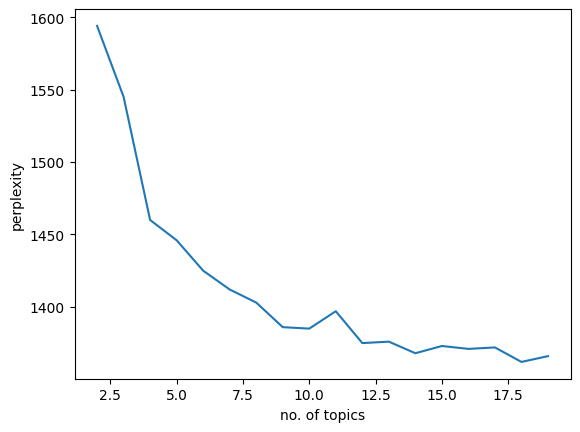

<Figure size 800x600 with 0 Axes>

In [7]:
######plotting the perplexity
import matplotlib.pyplot as plt
perplex= pd.read_csv('Reg_L_perplexities.csv', header=0)
y= perplex['perplexity']
x=perplex['topics']
plt.plot(x, y)
plt.xlabel('no. of topics',fontsize=10)
plt.ylabel('perplexity', fontsize=10)
plt.figure(figsize=(8, 6)) 

In [7]:
Meta= pd.read_csv('Reg_meta_L.csv', header=0, index_col=0)

In [8]:
my_obj.shape

(25699, 12302)

In [10]:
Meta.shape

(12302, 19)

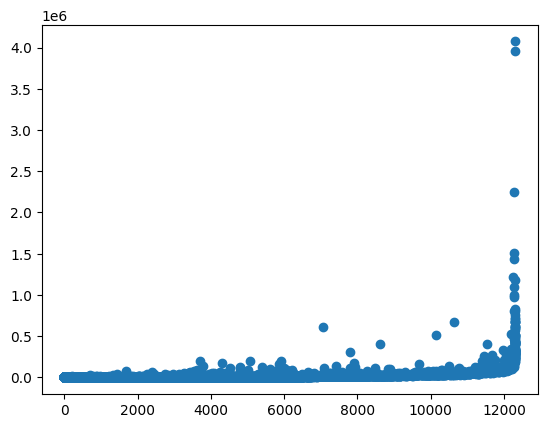

In [11]:
CountsAll= my_obj
plt.plot(CountsAll.astype(bool).sum(axis=1),CountsAll.sum(axis=1),'o')

In [12]:
countsAll= CountsAll
countsAll[(countsAll.astype(bool).sum(axis=1)>100) & (countsAll.astype(bool).sum(axis=1)<10000)]

,Patient6_AAACCCACAGCTTTGA.1,Patient6_AAACCCACATGAAGCG.1,Patient6_AAACCCACATGACTCA.1,Patient6_AAACCCAGTTAATCGC.1,Patient6_AAACGAACAAAGTATG.1,Patient6_AAACGAACAAATCCCA.1,Patient6_AAACGAAGTAGCTGAG.1,Patient6_AAACGAAGTGAGGATC.1,Patient6_AAACGCTCAGTAGAGC.1,Patient6_AAAGAACCAATTGCCA.1,...,Patient11_TTTGGTTTCCGTATGA.1,Patient11_TTTGGTTTCGAACTCA.1,Patient11_TTTGTTGAGTCGTCTA.1,Patient11_TTTGTTGCACCGTACG.1,Patient11_TTTGTTGCATCTGCGG.1,Patient11_TTTGTTGGTAATGCTC.1,Patient11_TTTGTTGGTAGCTGCC.1,Patient11_TTTGTTGTCAGCAATC.1,Patient11_TTTGTTGTCCGTGGTG.1,Patient11_TTTGTTGTCGCGCCAA.1
AL669831.5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
LINC00115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM41C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
NOC2L,0,2,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZIC1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KC877982.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC040170.1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
MAB21L2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0


In [13]:
countsFiltered = countsAll[(countsAll.astype(bool).sum(axis=1)>100) & (countsAll.astype(bool).sum(axis=1)<10000)]


In [14]:
countsFiltered

,Patient6_AAACCCACAGCTTTGA.1,Patient6_AAACCCACATGAAGCG.1,Patient6_AAACCCACATGACTCA.1,Patient6_AAACCCAGTTAATCGC.1,Patient6_AAACGAACAAAGTATG.1,Patient6_AAACGAACAAATCCCA.1,Patient6_AAACGAAGTAGCTGAG.1,Patient6_AAACGAAGTGAGGATC.1,Patient6_AAACGCTCAGTAGAGC.1,Patient6_AAAGAACCAATTGCCA.1,...,Patient11_TTTGGTTTCCGTATGA.1,Patient11_TTTGGTTTCGAACTCA.1,Patient11_TTTGTTGAGTCGTCTA.1,Patient11_TTTGTTGCACCGTACG.1,Patient11_TTTGTTGCATCTGCGG.1,Patient11_TTTGTTGGTAATGCTC.1,Patient11_TTTGTTGGTAGCTGCC.1,Patient11_TTTGTTGTCAGCAATC.1,Patient11_TTTGTTGTCCGTGGTG.1,Patient11_TTTGTTGTCGCGCCAA.1
AL669831.5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
LINC00115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM41C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
NOC2L,0,2,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZIC1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KC877982.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC040170.1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
MAB21L2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0


In [15]:
p = re.compile("RPS|RPL|RP")
list(filter(p.match,countsFiltered.index.values))

['RPS6KA1',
 'RPA2',
 'RPF1',
 'RPAP2',
 'RPRD2',
 'RPS6KC1',
 'RPIA',
 'RPRM',
 'RPE',
 'RPUSD3',
 'RPP14',
 'RPN1',
 'RPL39L',
 'RPL26L1',
 'RPP40',
 'RPP21',
 'RPS10-NUDT3',
 'RPL7L1',
 'RPF2',
 'RPS6KA2',
 'RPA3',
 'RP9',
 'RPS6KA3',
 'RPGR',
 'RP2',
 'RPS6KA6',
 'RPA4',
 'RPL36A',
 'RP1',
 'RPP25L',
 'RPS6KA4',
 'RPS6KB2',
 'RPUSD4',
 'RPP38',
 'RPP30',
 'RPAP3',
 'RPS6KL1',
 'RPS6KA5',
 'RPUSD2',
 'RPAP1',
 'RPS27L',
 'RPP25',
 'RPS17',
 'RPUSD1',
 'RPGRIP1L',
 'RPH3AL',
 'RPA1',
 'RPAIN',
 'RPS6KB1',
 'RPTOR',
 'RPRD1A',
 'RPL17',
 'RPN2',
 'RPRD1B',
 'RPS19BP1']

In [16]:
countsFiltered = countsFiltered.drop(list(filter(p.match,countsFiltered.index.values)),axis=0)

In [17]:
countsFiltered

,Patient6_AAACCCACAGCTTTGA.1,Patient6_AAACCCACATGAAGCG.1,Patient6_AAACCCACATGACTCA.1,Patient6_AAACCCAGTTAATCGC.1,Patient6_AAACGAACAAAGTATG.1,Patient6_AAACGAACAAATCCCA.1,Patient6_AAACGAAGTAGCTGAG.1,Patient6_AAACGAAGTGAGGATC.1,Patient6_AAACGCTCAGTAGAGC.1,Patient6_AAAGAACCAATTGCCA.1,...,Patient11_TTTGGTTTCCGTATGA.1,Patient11_TTTGGTTTCGAACTCA.1,Patient11_TTTGTTGAGTCGTCTA.1,Patient11_TTTGTTGCACCGTACG.1,Patient11_TTTGTTGCATCTGCGG.1,Patient11_TTTGTTGGTAATGCTC.1,Patient11_TTTGTTGGTAGCTGCC.1,Patient11_TTTGTTGTCAGCAATC.1,Patient11_TTTGTTGTCCGTGGTG.1,Patient11_TTTGTTGTCGCGCCAA.1
AL669831.5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
LINC00115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM41C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
NOC2L,0,2,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZIC1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KC877982.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC040170.1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
MAB21L2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0


In [18]:
referenceCells= Meta[Meta['neigb_class']=='Singlet']

In [19]:
Meta.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient', 'barcodes',
       'stage', 'percent.mt', 'RNA_snn_res.0.3', 'seurat_clusters',
       'ScType_cell', 'celltype_main', 'celltype_fine', 'refined_celltype',
       'new.clusters', 'final_clusters', 'neigb_class', 'neigb_type',
       'stage_num', 'stage_class'],
      dtype='object')

In [20]:
referenceCells.head

<bound method NDFrame.head of                                  orig.ident  nCount_RNA  nFeature_RNA   
Patient6_AAACCCACATGAAGCG-1   SeuratProject        7928          2213  \
Patient6_AAACCCACATGACTCA-1   SeuratProject        7066          1653   
Patient6_AAACCCAGTTAATCGC-1   SeuratProject        5807          1183   
Patient6_AAACGAACAAAGTATG-1   SeuratProject        9195          2241   
Patient6_AAACGAACAAATCCCA-1   SeuratProject        8638          2363   
...                                     ...         ...           ...   
Patient11_TTTGTTGCATCTGCGG-1  SeuratProject        8745          2639   
Patient11_TTTGTTGGTAATGCTC-1  SeuratProject       12264          2949   
Patient11_TTTGTTGGTAGCTGCC-1  SeuratProject       14840          3681   
Patient11_TTTGTTGTCAGCAATC-1  SeuratProject       10064          2860   
Patient11_TTTGTTGTCGCGCCAA-1  SeuratProject        9782          2335   

                                patient            barcodes stage  percent.mt   
Patient6_AAA

In [21]:
referenceCells.index = [i.replace("-",".") for i in referenceCells.index]
referenceCells.index

Index(['Patient6_AAACCCACATGAAGCG.1', 'Patient6_AAACCCACATGACTCA.1',
       'Patient6_AAACCCAGTTAATCGC.1', 'Patient6_AAACGAACAAAGTATG.1',
       'Patient6_AAACGAACAAATCCCA.1', 'Patient6_AAACGAAGTAGCTGAG.1',
       'Patient6_AAACGAAGTGAGGATC.1', 'Patient6_AAACGCTCAGTAGAGC.1',
       'Patient6_AAAGAACCAATTGCCA.1', 'Patient6_AAAGAACGTGGCAACA.1',
       ...
       'Patient11_TTTGGTTGTTGGTACT.1', 'Patient11_TTTGGTTTCCGTATGA.1',
       'Patient11_TTTGGTTTCGAACTCA.1', 'Patient11_TTTGTTGAGTCGTCTA.1',
       'Patient11_TTTGTTGCACCGTACG.1', 'Patient11_TTTGTTGCATCTGCGG.1',
       'Patient11_TTTGTTGGTAATGCTC.1', 'Patient11_TTTGTTGGTAGCTGCC.1',
       'Patient11_TTTGTTGTCAGCAATC.1', 'Patient11_TTTGTTGTCGCGCCAA.1'],
      dtype='object', length=11520)

In [22]:
countsFiltered.T

,AL669831.5,LINC00115,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,AL645608.8,HES4,ISG15,...,MKRN3,CNTNAP4,GLP2R,ZNF729,PTH2,ZIC1,KC877982.1,AC040170.1,MAB21L2,LINC02135
Patient6_AAACCCACAGCTTTGA.1,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
Patient6_AAACCCACATGAAGCG.1,0,0,0,0,2,0,0,0,1,9,...,0,0,0,0,0,0,0,0,0,0
Patient6_AAACCCACATGACTCA.1,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
Patient6_AAACCCAGTTAATCGC.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Patient6_AAACGAACAAAGTATG.1,0,0,0,0,0,0,0,0,4,7,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Patient11_TTTGTTGGTAATGCTC.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
Patient11_TTTGTTGGTAGCTGCC.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Patient11_TTTGTTGTCAGCAATC.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
Patient11_TTTGTTGTCCGTGGTG.1,1,0,0,0,2,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [23]:
referenceCounts= countsFiltered[referenceCells.index]

In [24]:
referenceCounts

,Patient6_AAACCCACATGAAGCG.1,Patient6_AAACCCACATGACTCA.1,Patient6_AAACCCAGTTAATCGC.1,Patient6_AAACGAACAAAGTATG.1,Patient6_AAACGAACAAATCCCA.1,Patient6_AAACGAAGTAGCTGAG.1,Patient6_AAACGAAGTGAGGATC.1,Patient6_AAACGCTCAGTAGAGC.1,Patient6_AAAGAACCAATTGCCA.1,Patient6_AAAGAACGTGGCAACA.1,...,Patient11_TTTGGTTGTTGGTACT.1,Patient11_TTTGGTTTCCGTATGA.1,Patient11_TTTGGTTTCGAACTCA.1,Patient11_TTTGTTGAGTCGTCTA.1,Patient11_TTTGTTGCACCGTACG.1,Patient11_TTTGTTGCATCTGCGG.1,Patient11_TTTGTTGGTAATGCTC.1,Patient11_TTTGTTGGTAGCTGCC.1,Patient11_TTTGTTGTCAGCAATC.1,Patient11_TTTGTTGTCGCGCCAA.1
AL669831.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
LINC00115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM41C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
NOC2L,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZIC1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KC877982.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC040170.1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
MAB21L2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0


In [25]:
doubletCells= Meta[Meta['neigb_class']=='Doublet']

In [26]:
doubletCells.head

<bound method NDFrame.head of                                  orig.ident  nCount_RNA  nFeature_RNA   
Patient6_AAACCCACAGCTTTGA-1   SeuratProject       15362          3273  \
Patient6_AAAGGTATCATGGTAC-1   SeuratProject       30271          5431   
Patient6_AACCCAAGTGGCCCAT-1   SeuratProject       27679          4925   
Patient6_AACGGGAGTATCCTTT-1   SeuratProject       18831          2959   
Patient6_AACGTCAAGATCGCCC-1   SeuratProject       18142          3014   
...                                     ...         ...           ...   
Patient11_TTTCGATAGAGCCGTA-1  SeuratProject       14272          3093   
Patient11_TTTGACTTCCAGCAAT-1  SeuratProject       18536          4125   
Patient11_TTTGACTTCTTCGGTC-1  SeuratProject       10612          3029   
Patient11_TTTGGAGCACTAGGCC-1  SeuratProject       14364          3387   
Patient11_TTTGTTGTCCGTGGTG-1  SeuratProject       24665          4493   

                                patient            barcodes stage  percent.mt   
Patient6_AAA

In [27]:
doubletCells.index = [i.replace("-",".") for i in doubletCells.index]
doubletCells.index

Index(['Patient6_AAACCCACAGCTTTGA.1', 'Patient6_AAAGGTATCATGGTAC.1',
       'Patient6_AACCCAAGTGGCCCAT.1', 'Patient6_AACGGGAGTATCCTTT.1',
       'Patient6_AACGTCAAGATCGCCC.1', 'Patient6_AAGACTCGTAGATCGG.1',
       'Patient6_AATCACGCACACCTTC.1', 'Patient6_AATGCCACAGTAACCT.1',
       'Patient6_ACACGCGTCACACGAT.1', 'Patient6_ACATGCATCATGCTAG.1',
       ...
       'Patient11_TTGTTGTAGAATAACC.1', 'Patient11_TTGTTGTCATAATGCC.1',
       'Patient11_TTTAGTCGTCTGATAC.1', 'Patient11_TTTCATGTCCACCTCA.1',
       'Patient11_TTTCCTCCATGACACT.1', 'Patient11_TTTCGATAGAGCCGTA.1',
       'Patient11_TTTGACTTCCAGCAAT.1', 'Patient11_TTTGACTTCTTCGGTC.1',
       'Patient11_TTTGGAGCACTAGGCC.1', 'Patient11_TTTGTTGTCCGTGGTG.1'],
      dtype='object', length=782)

In [28]:
doubletsCounts = countsFiltered[doubletCells.index]
doubletsCounts.shape

(14262, 782)

In [29]:
#setting up LDA
singleCellLDA = VariationalLDA(K = 15,alpha = 1,eta=0.005,update_alpha=True)
singleCellLDA.load_data_sc(referenceCounts)
singleCellLDA.run_vb(n_its = 50,initialise=True)

Edited
Initialising
Starting iterations


/tmp/ipykernel_132818/2249788462.py:224: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 25.390271812592818) (194.1149616241455 seconds, I think I'll finish in 161.76246802012125 minutes). Alpha: (25.398583771854874,34.310911757891596)
Iteration 1 (change = 0.041406381479024694) (185.10986304283142 seconds, I think I'll finish in 151.17305481831232 minutes). Alpha: (27.84547105126653,37.62049706378032)
Iteration 2 (change = 0.04083941924792706) (185.06624102592468 seconds, I think I'll finish in 148.05299282073975 minutes). Alpha: (28.26797637211089,38.16140976036126)
Iteration 3 (change = 0.04093865186163476) (185.90538811683655 seconds, I think I'll finish in 145.62588735818863 minutes). Alpha: (28.227695932060833,38.0709961096728)
Iteration 4 (change = 0.04131522523856878) (187.44433879852295 seconds, I think I'll finish in 143.70732641220093 minutes). Alpha: (28.07466966357777,37.827723311069334)
Iteration 5 (change = 0.04175286226929308) (186.53391551971436 seconds, I think I'll finish in 139.90043663978577 minutes). Alpha: (27.893040987347533,37

In [30]:
topic_dict = pd.DataFrame(singleCellLDA.beta_matrix,index=None).to_dict(orient='index')

In [31]:
scLDA = VariationalLDA(corpus=singleCellLDA.corpus,K=20,
                       word_index=singleCellLDA.word_index,
                       alpha=1,eta=0.0005,update_alpha=True, fixed_topics=topic_dict)

Object created with 11520 documents


In [32]:
wordTopic = pd.DataFrame(singleCellLDA.beta_matrix, columns=referenceCounts.index)

In [33]:
scLDA.load_data_sc(doubletsCounts)

Edited


In [34]:
scLDA.run_vb(n_its=100,initialise=True)

Initialising
Here
Starting iterations


/tmp/ipykernel_132818/2249788462.py:224: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 24.803353015230172) (21.38332962989807 seconds, I think I'll finish in 35.63888271649679 minutes). Alpha: (0.8416344759433054,28.078982406848596)
Iteration 1 (change = 3.9690415560915486) (19.135679483413696 seconds, I think I'll finish in 31.573871147632598 minutes). Alpha: (0.5183512499026129,19.83349133209547)
Iteration 2 (change = 3.0397324249134847) (19.082881450653076 seconds, I think I'll finish in 31.168706369400024 minutes). Alpha: (0.40707155214200713,16.810809546011388)
Iteration 3 (change = 2.7572362076354096) (19.078882694244385 seconds, I think I'll finish in 30.844193689028423 minutes). Alpha: (0.31389338983066095,15.260367455778773)
Iteration 4 (change = 2.8123938460841083) (19.37600040435791 seconds, I think I'll finish in 31.001600646972655 minutes). Alpha: (0.24015011153714738,14.268495643606293)
Iteration 5 (change = 3.4557484389073676) (19.123555183410645 seconds, I think I'll finish in 30.27896237373352 minutes). Alpha: (0.19688794184867525,1

In [35]:
scLDA.beta_matrix.shape

(35, 14262)

In [36]:
scLDA.get_expect_theta().shape

(782, 35)

In [37]:
wordTopicNew = pd.DataFrame(scLDA.beta_matrix, columns=referenceCounts.index)


In [38]:
doubletsCounts.shape

(14262, 782)

In [39]:

interesting_genes = ranking_genes(15,35,scLDA, doubletsCounts.index)

In [40]:
interesting_genes[interesting_genes[3]==18].sort_values(1,ascending=False)[0:20]

,0,1,2,3
5483,GAS6,110,0.413534,[18]
7246,C3,107,0.507109,[18]
2985,SFRP4,107,0.554404,[18]
4993,MGP,105,0.328125,[18]
6407,SERPINF1,105,0.152616,[18]
4575,TAGLN,103,0.262755,[18]
3441,TCEAL4,103,0.147989,[18]
4325,SERPING1,103,0.35274,[18]
1617,CCDC80,101,0.448889,[18]
708,PRELP,100,0.826446,[18]


In [41]:
interesting_genes.to_csv('Reg_L_genes.csv', index=False)

In [250]:
#interesting_genes= pd.read_csv('B_Can_genes.csv', header=0)


In [42]:
#int_genes = interesting_genes.groupby(0).filter(lambda x: len(x)<10)
int_genes= interesting_genes


In [43]:
final_genes = []
for i in range(11,34):
    g = int_genes[int_genes[3]==i].sort_values([1],ascending=False)[0:20][0].values
    final_genes.append(list(g))

In [44]:
final_genes = [item for sublist in final_genes for item in sublist]

In [45]:
final_genes

['CXCL8',
 'PDLIM4',
 'MT2A',
 'TM4SF1',
 'IQCG',
 'TUBB2A',
 'CTSL',
 'TNFRSF12A',
 'CD55',
 'INHBA',
 'SNX9',
 'UFM1',
 'OAF',
 'PSME2',
 'NAMPT',
 'ANXA1',
 'TUBA1C',
 'GFPT2',
 'CTHRC1',
 'MED10',
 'ANXA11',
 'CCND1',
 'TJP1',
 'KRT7',
 'UCHL3',
 'PLAU',
 'TBL1XR1',
 'MAL2',
 'EIF6',
 'EIF4G1',
 'CCT2',
 'HMGA1',
 'EBNA1BP2',
 'AFDN',
 'PRMT1',
 'ANXA3',
 'NOL7',
 'PPP2R2A',
 'EIF3A',
 'IGF2BP2',
 'CDKN2A',
 'TYMP',
 'CD40',
 'GBP2',
 'SRGN',
 'CTSS',
 'ACO1',
 'SAA1',
 'PARP14',
 'TMBIM4',
 'GSN',
 'C1S',
 'MED13L',
 'SQOR',
 'LAP3',
 'SAA2',
 'LYRM4',
 'RAB13',
 'TMEM165',
 'C1R',
 'GAS6',
 'C3',
 'SFRP4',
 'MGP',
 'SERPINF1',
 'TAGLN',
 'TCEAL4',
 'SERPING1',
 'CCDC80',
 'PRELP',
 'CFH',
 'MYL9',
 'SMOC2',
 'DUSP1',
 'ACTA2',
 'EFEMP1',
 'ADIRF',
 'C7',
 'IGFBP4',
 'DCN',
 'PENK',
 'S100A1',
 'ANGPTL6',
 'NDUFA9',
 'APRT',
 'PGAM1',
 'TRAPPC2B',
 'NDUFS6',
 'PRMT1',
 'NDUFB8',
 'NME4',
 'ATP5MC1',
 'SFRP2',
 'POLR2K',
 'PSME2',
 'UQCRQ',
 'SELENOM',
 'C4orf48',
 'DPY30',
 'NHP2'

In [46]:
len(list(set(final_genes)))

346

In [47]:
final_genes= list(set(final_genes))

In [48]:
print(len(final_genes))
final_genes= pd.DataFrame(final_genes)
#final_genes.to_csv('B_Can_AllGenes.csv')

346


In [49]:
refC = referenceCounts.T.merge(referenceCells,left_index=True,right_index=True)
refC = refC.sort_values(by="seurat_clusters")
refC = refC.drop(referenceCells.columns, axis=1)
allCounts = pd.merge(refC.T,doubletsCounts,left_index=True,right_index=True)
colours = ['blue' if x in refC.index else "red" for x in allCounts.columns]
topicWords = pd.DataFrame(scLDA.beta_matrix,columns=allCounts.index)

: 

: 

In [ ]:
from matplotlib.transforms import Bbox
sb.set(font_scale=9)
blue_ref = mpatches.Patch(color="blue", label="reference")
red_dbls = mpatches.Patch(color="red", label="doublets")
legend_TN = [blue_ref, red_dbls]
heatmapCV = sb.clustermap(np.log1p(allCounts.loc[["TNFSF10",
                                                  "FOS","IFI16","ITM2B","ITGB1"]]),row_cluster=False, col_cluster=False, 
               figsize=(80,80),robust=True,cmap='coolwarm',col_colors = colours)

heatmapCV.ax_heatmap.set_xticks([])
heatmapCV.ax_heatmap.set_yticklabels(heatmapCV.ax_heatmap.get_yticklabels(), rotation = 0, fontsize = 120)
heatmapCV.ax_heatmap.set_xlabel("Cells",fontsize=200)
heatmapCV.ax_heatmap.set_ylabel("Genes",fontsize=200)
l2 = heatmapCV.ax_heatmap.legend(loc='center right',bbox_to_anchor=(1.40,0.85),handles=legend_TN,frameon=False,
                                fontsize="large")
heatmapCV.cax.set_position(pos=Bbox(np.array([[0.16,0.3],[0.17,0.7]])))
plt.show()


In [53]:
#plt.savefig("Xu_L.png",dpi=100,bbox_inches="tight")

<Figure size 640x480 with 0 Axes>